# Phase 3 Data Science Training Notebook

In [38]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statistics as st
from functions import*

## Exploratory Data Analysis

In [39]:
folder='cifar-10-batches\\' # folder name that contains cifar-10 files
# training,test and name variables 
train_batch1=unpickle(folder+'data_batch_1')
test=unpickle(folder+'test_batch')
label_names=unpickle(folder+'batches.meta')['label_names']


In [40]:
# display shape of dataset
ShapeOfData='variable: train_batch1 %s\n'%str(type(train_batch1))
ShapeOfData+='-------------------------------------\n'
ShapeOfData+=f'{"key": <13} size'+f'{"": <11}dtype\n' 
ShapeOfData+=f'{"---": <13} ----'+f'{"": <11}-----\n'
for key in train_batch1.keys():
    string=f'{key: <13} %s'%str(np.shape(train_batch1[key]))
    ShapeOfData+=f'{string: <29}%s'%str(type(train_batch1[key]))
    ShapeOfData+='\n'
print(ShapeOfData)

variable: train_batch1 <class 'dict'>
-------------------------------------
key           size           dtype
---           ----           -----
batch_label   ()             <class 'str'>
labels        (10000,)       <class 'list'>
data          (10000, 3072)  <class 'numpy.ndarray'>
filenames     (10000,)       <class 'list'>



In [41]:
# store training batches (1 to 5) in one variable
# reshape rgb data 2d (nx3072) array to 4d (nx32x32x3) for both test and training data
train_batches=[]
for num in range(1,6):
    dict=unpickle(folder+'data_batch_'+str(num))
    dict['data']=np.reshape(dict['data'],(10000,3,32,32))   
    dict['data']=np.transpose(dict['data'],[0,2,3,1])
    # remove keys that is unnecessary in this analysis
    dict.pop('batch_label')
    dict.pop('filenames')
    train_batches.append(dict)
# remove keys that is unnecessary in this analysis
test.pop('batch_label')
test.pop('filenames')
test['data']=np.reshape(test['data'],(10000,3,32,32))  
test['data']=np.transpose(test['data'],[0,2,3,1])

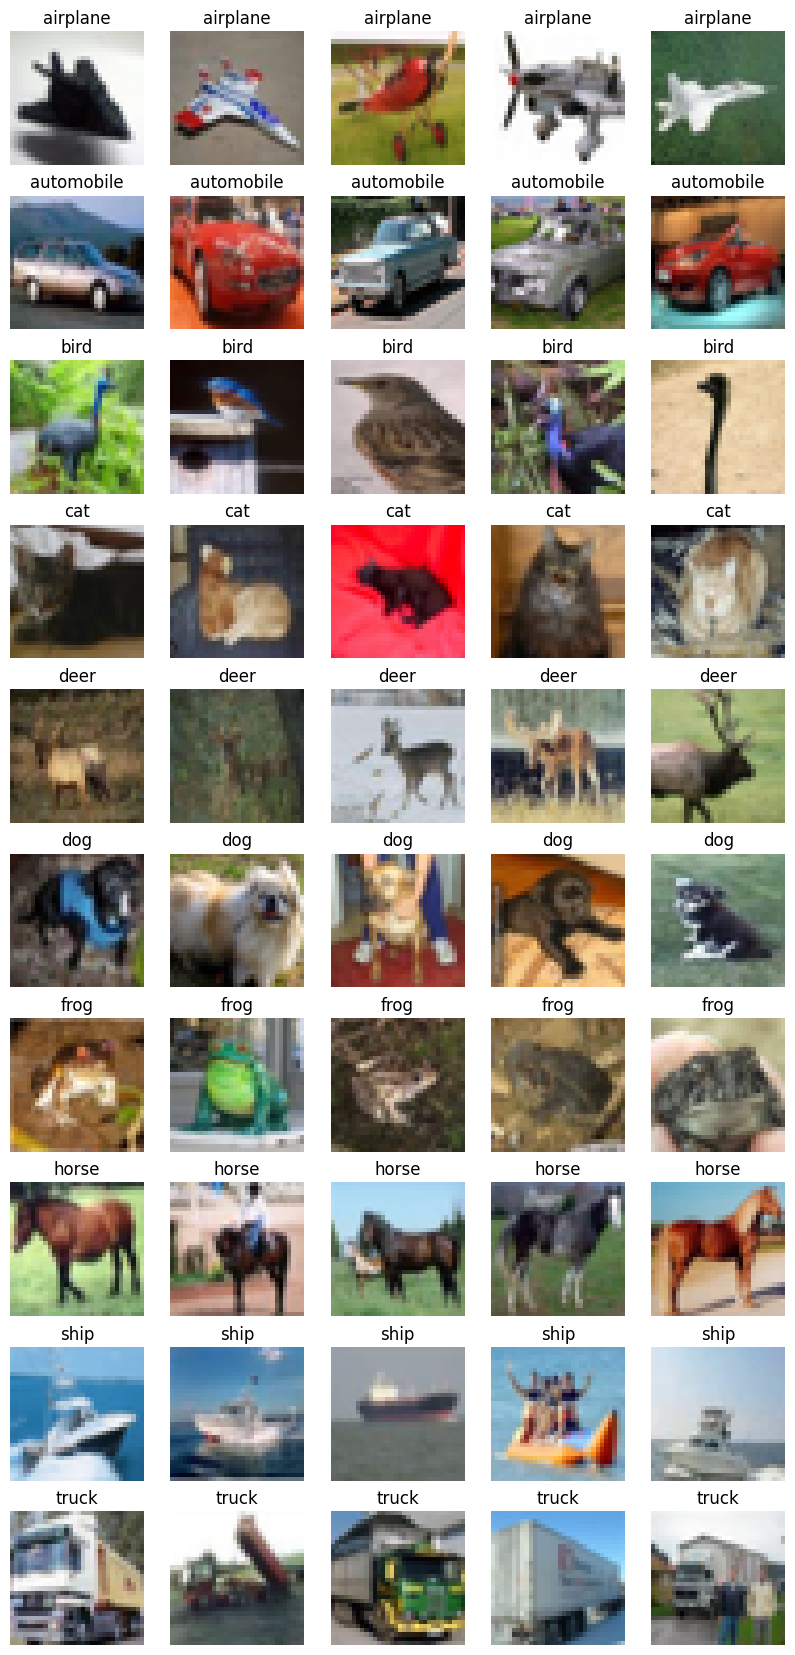

In [42]:
# render first 5 images in batch1 training set for each label
from PIL import Image
import matplotlib.pyplot as plt

train=train_batches[0]
num=0
plt.figure(figsize=(10, 21))
for label in range(10):
    for idx in np.where(np.array(train['labels'])==label)[0][0:5]:
        ax = plt.subplot(10, 5, num + 1)
        plt.imshow(train['data'][idx])
        plt.axis('off')  
        plt.title(label_names[label])  
        num+=1 

In [43]:
# label choice for the model
label_choice=['cat','cat','automobile','automobile']    

# Data Processing

In [44]:
# split training batches to label and image batches
train_images_batches = [train['data'] for train in train_batches]
train_labels_batches = np.array([train['labels'] for train in train_batches])
# combine batches to one batch
train_labels_combined=np.reshape(train_labels_batches,(50000))
train_images_combined=np.reshape(train_images_batches,(50000,32,32,3))
# get 10000 training and 2000 test samples
train_labels,train_images=get_sample(train_labels_combined,train_images_combined,40000)
test_labels,test_images=get_sample(np.array(test['labels']),test['data'],8000)

# Data Modelling

In [45]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks

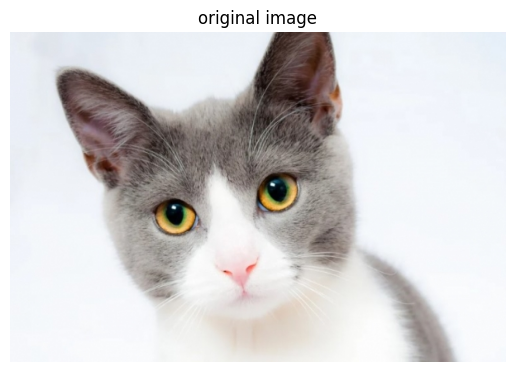

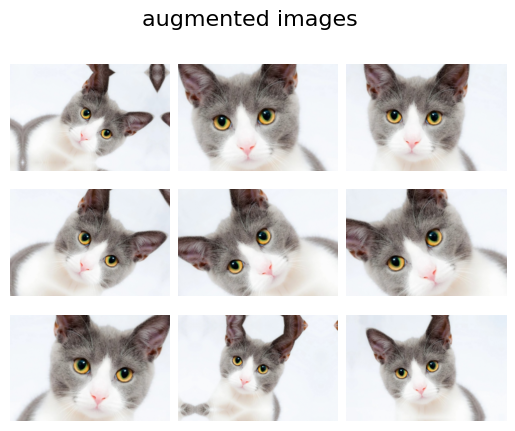

In [46]:
from tensorflow import keras
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.3),
])

from io import BytesIO
import requests
# get image by request
response=requests.get("http://www.chemicalnews.co.kr/news/photo/202106/3636_10174_4958.jpg")
img=Image.open(BytesIO(response.content))
# distplay original image
plt.imshow(img)
plt.title('original image')
img=np.array(img)
plt.axis("off")
# display augmented image
fig=plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle('augmented images',fontsize=16)
for i in range(9):
  augmented_images = data_augmentation(tf.expand_dims(img, 0),training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

In [47]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [48]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(train_images, train_labels, epochs=50, validation_data=(test_images,test_labels), 
callbacks=[stop_early,ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal drop out ratio is {best_hps.get('dropout')}, the optimal number of units in the last densely-connected 
layer is {best_hps.get('units')} and the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json
INFO:tensorflow:Oracle triggered exit

The optimal drop out ratio is 0.15, the optimal number of units in the last densely-connected 
layer is 192 and the optimal learning rate for the optimizeris 0.001.



In [49]:
tuner.search_space_summary(extended=False)
# get summary result for hyperparameter tuning
summary_dict=load_hyperParamSummary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.1, 0.15], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


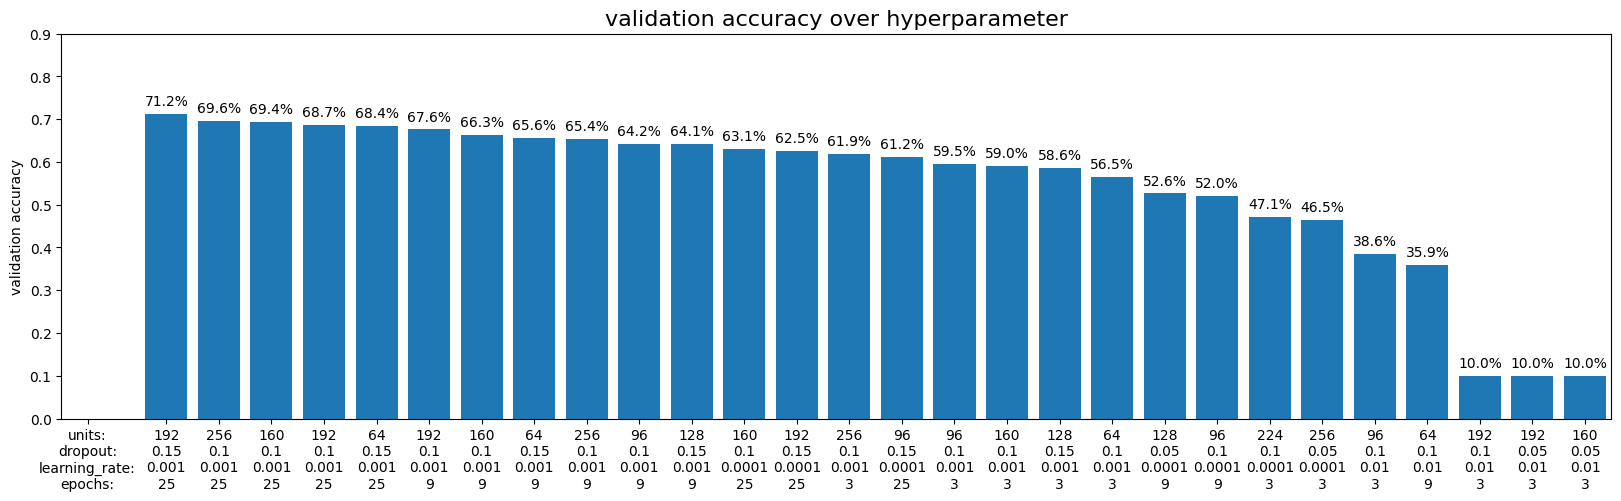

In [50]:
x=[i for i in range(2,30)]
plt.figure(figsize=(20,5))
plt.xticks([0.5]+x,['units:\ndropout:\nlearning_rate:\nepochs:']+summary_dict['combined'])
plt.bar([0.5]+x,[0]+summary_dict['Score'])
plt.xlim([0,29.5])
plt.ylim([0,.9])
for i in range(2,30):
    plt.text(i,summary_dict['Score'][i-2]+0.02,'{:.1f}%'.format(100*summary_dict['Score'][i-2]), ha = 'center',fontsize=10)
plt.title('validation accuracy over hyperparameter',fontsize=16)
plt.ylabel('validation accuracy')
plt.show()

In [51]:
import os.path
import json
# check the history alredy exist
if os.path.isfile('output\history'):
    #load the model
    history= json.load(open('output\history', 'r'))

    # print the result
    val_acc_per_epoch = history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,)) 
else:
    # Build the model with the optimal hyperparameters and train it on the data for 80 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_images, train_labels, epochs=80, validation_data=(test_images,test_labels))

    # save model
    # create directory and Save it under the form of a json file
    os.mkdir('output')
    json.dump(history.history, open('output\history', 'w'))
    
    # print the result
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))    

Best epoch: 70


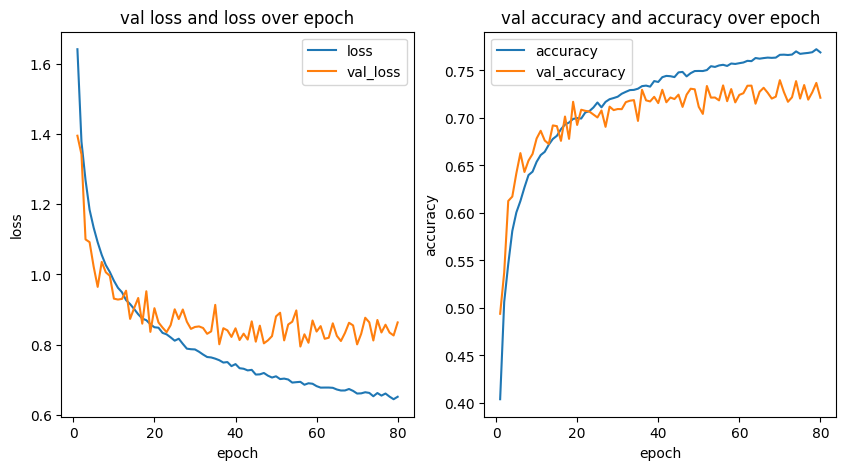

In [52]:
# plotting the result
t=np.linspace(1,80,80)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t,history['loss'],label='loss')
ax1.plot(t,history['val_loss'],label='val_loss')
ax1.set_title('val loss and loss over epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(t,history['accuracy'],label='accuracy')
ax2.plot(t,history['val_accuracy'],label='val_accuracy')
ax2.set_title('val accuracy and accuracy over epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
fig.set_figwidth(10)
fig.set_figheight(5)

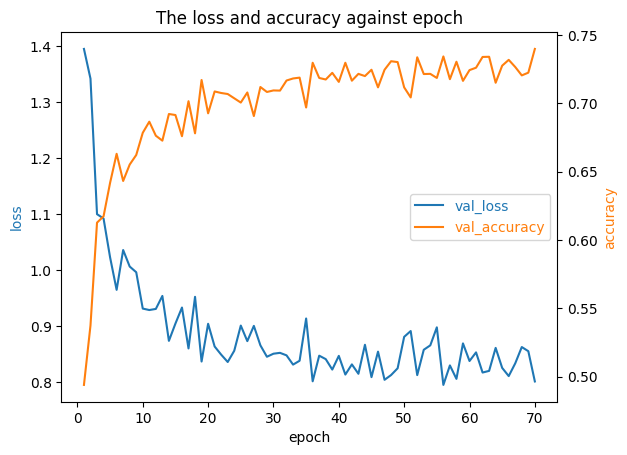

In [53]:
from mpl_toolkits.axes_grid1 import host_subplot
loss = host_subplot(111)
accuracy = loss.twinx()
plt.title('The loss and accuracy against epoch')
loss.set_xlabel("epoch")
loss.set_ylabel("loss")
accuracy.set_ylabel("accuracy")
p1, = loss.plot(t[0:70],(history['val_loss'])[0:70], label="val_loss")
p2, = accuracy.plot(t[0:70],(history['val_accuracy'])[0:70], label="val_accuracy")
leg = plt.legend()
loss.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())
accuracy.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

In [54]:
# check if the model already exist
if os.path.isfile('output\my_model'):
    #load the model
    hypermodel = tf.keras.models.load_model('output\my_model')
else:
    # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(train_images, train_labels, epochs=best_epoch)

    # save model
    hypermodel.save('output\my_model', save_format="h5")

In [55]:
hypermodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 32, 32, 3)         0         
                                                                 
 resizing_3 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        448       
                                                      

In [56]:
# result
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

250/250 [==============================] - 2s 8ms/step - loss: 0.8277 - accuracy: 0.7374
[test loss, test accuracy]: [0.8277215361595154, 0.737375020980835]


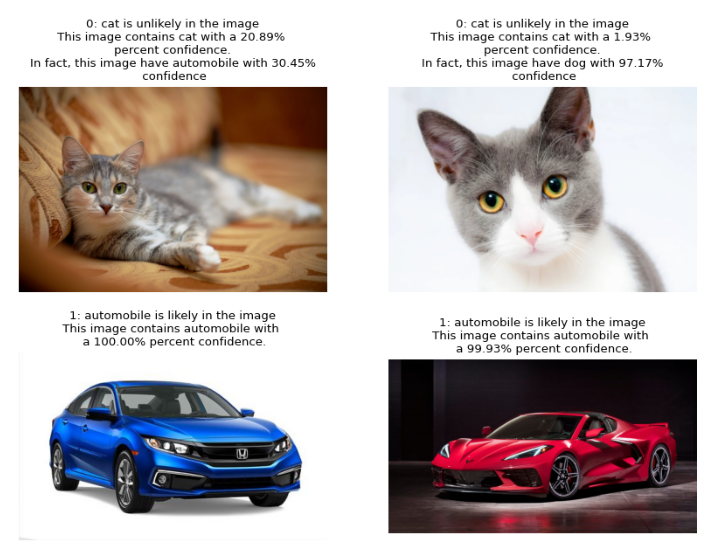

In [57]:
from PIL import Image
# if there is an image
if os.path.isfile('image/predict.png'):
  img = Image.open('image/predict.png')
  plt.figure(figsize=(10, 7))
  plt.axis('off')
  plt.imshow(img)
else:  
  # otherwise bring cat and automobile images and try on prediciton model
  img=[Image.open('image/cat0.png'),
  Image.open('image/cat1.png'),
  Image.open('image/car2.png'),
  Image.open('image/car3.png')
  ]
  plt.figure(figsize=(10, 7))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    label,percent,realLabel,bestpercent=predict(img[i],label_choice[i],'on')
    plt.imshow(img[i])
    plt.axis('off')
    # print the result
    if label:
      comment='is likely in the image'
    else:
      comment='is unlikely in the image'
    if label==1:
      plt.title("{}: {} {}\nThis image contains {} with \n a {:.2f}% percent confidence."
          .format(label,label_choice[i],comment,label_choice[i],percent))
    elif label==0:
      plt.title("{}: {} {}\nThis image contains {} with a {:.2f}% \npercent confidence.\nIn fact, this image have {} with {:.2f}%\n confidence"
      .format(label,label_choice[i],comment,label_choice[i],percent,realLabel,bestpercent))   
  plt.show()      

In [58]:
# accuracy on each class model using corresponding class images 
result={}
for label in label_names:
    # get index of labels that matches the class
    idx=np.where(test_labels==label_names.index(label))

    # call the prediction model and get result
    plabel,percent=predict(test_images[idx],label)
    result[str(label)]=plabel

# accuracy of each class model when tested with corresponding class image 
result['accuracy']=[]
for label in label_names:
    percent=np.mean(result[label])
    result['accuracy'].append(percent)   
    print('{}: {:.2f}%'.format(label,percent*100))
            

airplane: 83.25%
automobile: 91.62%
bird: 55.75%
cat: 50.75%
deer: 70.88%
dog: 66.75%
frog: 79.50%
horse: 80.12%
ship: 75.88%
truck: 82.88%


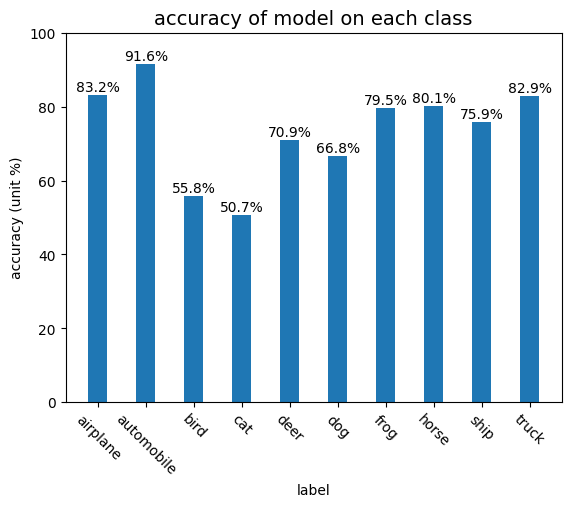

In [59]:
plt.bar(label_names,np.array(result['accuracy'])*100,width = 0.4)
plt.xlabel("label")
plt.ylabel("accuracy (unit %)")
plt.title("accuracy of model on each class",fontsize=14)
plt.xticks(rotation=315)
plt.ylim([0,100])
for i in range(10):
    plt.text(i,100*np.array(result['accuracy'][i])+1,'{:.1f}%'.format(100*np.array(result['accuracy'][i])), ha = 'center',fontsize=10)
plt.rc('xtick', labelsize=10)

In [60]:
# accuracy of each class model with all test images
result=[]
confInterval=[]
print('confidence interval for model accuracy')
for label in label_names:
    # call predict 
    pred_label,pred_percentage=predict(test_images,label)
    # change label to 1 if label match, 0 otherwise
    test_label=(test_labels==label_names.index(label))
    # calculate accuracy for themodel
    percent=np.sum(test_label==pred_label)/8000*100
    result.append(percent)
    # calculate 95% confidence interval ()
    sd=st.stdev((test_label==pred_label).astype(np.float))
    confInterval.append(sd*1.96*100/np.sqrt(8000))
    print('{}: {:.2f}% to {:.2f}%'.format(label,percent-confInterval[-1],percent+confInterval[-1]))

confidence interval for model accuracy
airplane: 94.13% to 95.12%
automobile: 95.56% to 96.42%
bird: 93.23% to 94.29%
cat: 91.48% to 92.67%
deer: 94.27% to 95.25%
dog: 92.95% to 94.03%
frog: 95.52% to 96.38%
horse: 95.26% to 96.14%
ship: 96.03% to 96.84%
truck: 94.20% to 95.18%


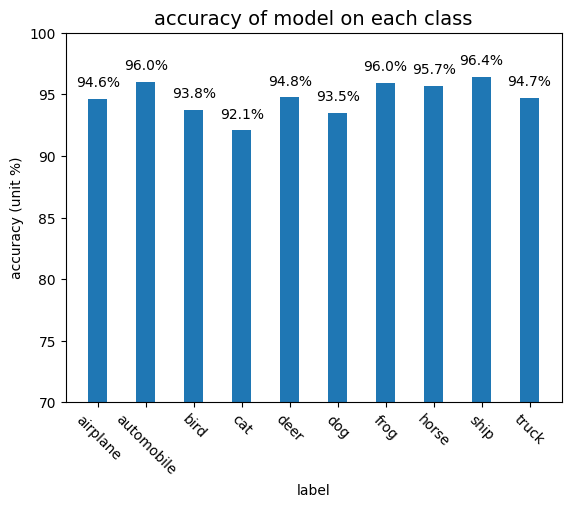

In [61]:
plt.bar(label_names,np.array(result),width = 0.4)
plt.xlabel("label")
plt.ylabel("accuracy (unit %)")
plt.title("accuracy of model on each class",fontsize=14)
plt.xticks(rotation=315)
plt.ylim([70,100])
for i in range(10):
    plt.text(i,np.array(result[i])+1,'{:.1f}%'.format(np.array(result[i])), ha = 'center',fontsize=10)
plt.rc('xtick', labelsize=10)

In [62]:
label_names,test_labels,test_images=load_image_data()
# result
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

250/250 [==============================] - 3s 10ms/step - loss: 0.8277 - accuracy: 0.7374
[test loss, test accuracy]: [0.8277215361595154, 0.737375020980835]
